In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [15]:
class COVIDNetClassifierLarge(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(COVIDNetClassifierLarge, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.classifier(x)

In [16]:
# Load data
def load_data(split, data_dir):
    features = np.load(os.path.join(data_dir, f"{split}_features.npy"))
    labels = np.load(os.path.join(data_dir, f"{split}_labels.npy"))
    return torch.tensor(features, dtype=torch.float32), torch.tensor(labels, dtype=torch.long)

In [17]:
# Plotting helper
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses)+1)
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Train Loss')
    plt.plot(epochs, val_losses, 'r-', label='Val Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'b-', label='Train Acc')
    plt.plot(epochs, val_accuracies, 'r-', label='Val Acc')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

In [18]:
def evaluate(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    y_pred = []
    y_true = []
    
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            loss = criterion(outputs, yb)
            test_loss += loss.item()  # Accumulate the test loss
            
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == yb).sum().item()
            total += yb.size(0)
            
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(yb.cpu().numpy())
    
    average_test_loss = test_loss / len(test_loader)
    accuracy = correct / total
    return y_pred, y_true, average_test_loss, accuracy

In [19]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=50):
    model.to(device)
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    best_acc = 0.0

    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0.0, 0, 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            outputs = model(xb)
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct += (outputs.argmax(1) == yb).sum().item()
            total += yb.size(0)

        train_losses.append(total_loss / len(train_loader))
        train_accuracies.append(correct / total)

        # Validation
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                outputs = model(xb)
                loss = criterion(outputs, yb)
                val_loss += loss.item()
                correct += (outputs.argmax(1) == yb).sum().item()
                total += yb.size(0)

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(correct / total)

        if val_accuracies[-1] > best_acc:
            best_acc = val_accuracies[-1]
            torch.save(model.state_dict(), "resnet_covidnet_large.pt")

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, "
              f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies

Epoch 1/50 - Train Loss: 0.6331, Train Acc: 0.7416, Val Loss: 0.3962, Val Acc: 0.8532
Epoch 2/50 - Train Loss: 0.4497, Train Acc: 0.8238, Val Loss: 0.3434, Val Acc: 0.8682
Epoch 3/50 - Train Loss: 0.4024, Train Acc: 0.8441, Val Loss: 0.3084, Val Acc: 0.8863
Epoch 4/50 - Train Loss: 0.3650, Train Acc: 0.8589, Val Loss: 0.2898, Val Acc: 0.8905
Epoch 5/50 - Train Loss: 0.3435, Train Acc: 0.8651, Val Loss: 0.2813, Val Acc: 0.8935
Epoch 6/50 - Train Loss: 0.3288, Train Acc: 0.8732, Val Loss: 0.3584, Val Acc: 0.8606
Epoch 7/50 - Train Loss: 0.3068, Train Acc: 0.8797, Val Loss: 0.2822, Val Acc: 0.8909
Epoch 8/50 - Train Loss: 0.2876, Train Acc: 0.8886, Val Loss: 0.3010, Val Acc: 0.8831
Epoch 9/50 - Train Loss: 0.2854, Train Acc: 0.8893, Val Loss: 0.2680, Val Acc: 0.9005
Epoch 10/50 - Train Loss: 0.2725, Train Acc: 0.8958, Val Loss: 0.2511, Val Acc: 0.9027
Epoch 11/50 - Train Loss: 0.2618, Train Acc: 0.8977, Val Loss: 0.2905, Val Acc: 0.8872
Epoch 12/50 - Train Loss: 0.2583, Train Acc: 0.9004,

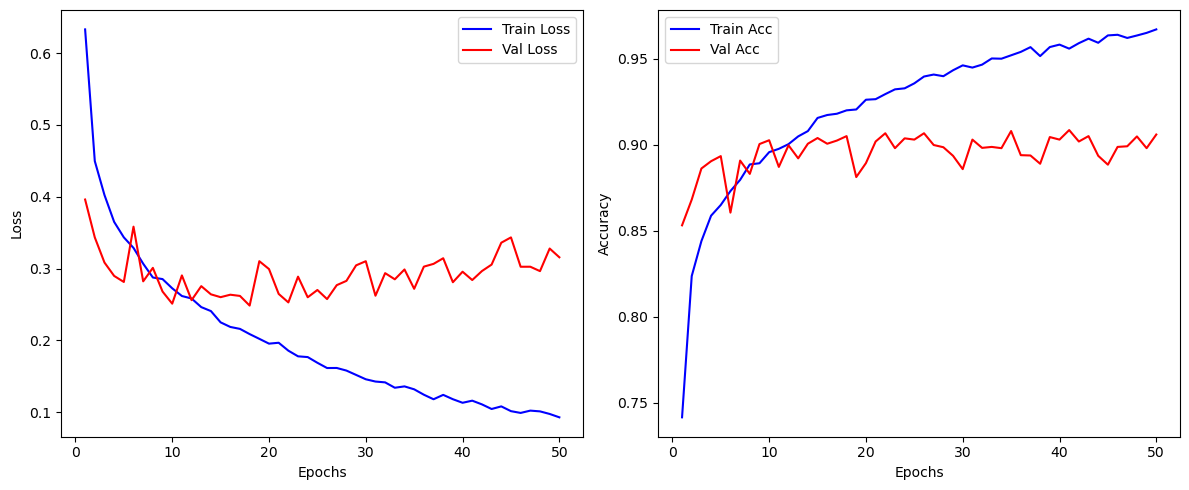

C:\Users\Safi\AppData\Local\Temp\ipykernel_31384\2829335355.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("resnet_covidnet_large.pt")

Test Loss: 0.2434
Test Accuracy: 0.9227


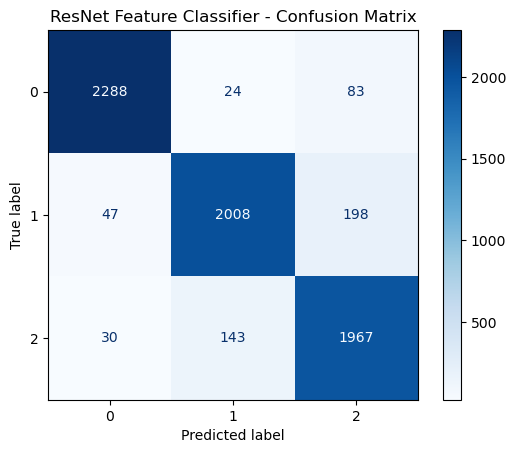

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.96      2395
           1       0.92      0.89      0.91      2253
           2       0.88      0.92      0.90      2140

    accuracy                           0.92      6788
   macro avg       0.92      0.92      0.92      6788
weighted avg       0.92      0.92      0.92      6788



In [20]:
# Main execution
if __name__ == "__main__":
    batch_size = 32
    num_classes = 3  # Adjust if needed

    # Load feature and label tensors
    X_train, y_train = load_data("train", "resnet_dataset/train")
    X_val, y_val = load_data("val", "resnet_dataset/val")
    X_test, y_test = load_data("test", "resnet_dataset/test")

    # Determine input dim
    input_dim = X_train.shape[1]

    # Dataloaders
    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size)
    test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size)

    # Model
    model = COVIDNetClassifierLarge(input_dim=input_dim, num_classes=num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    # Train
    train_losses, val_losses, train_accs, val_accs = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=50)

    # Plot metrics
    plot_metrics(train_losses, val_losses, train_accs, val_accs)

    # Load best model and evaluate
    model.load_state_dict(torch.load("resnet_covidnet_large.pt"))
    y_pred, y_true, test_loss, accuracy = evaluate(model, test_loader, criterion)
    
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("ResNet Feature Classifier - Confusion Matrix")
    plt.show()

    # Classification Report
    print("Classification Report:\n", classification_report(y_true, y_pred))